In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
from scipy import integrate
from SPNO_1d import *

In [2]:
x_data = np.load('data/spde_ib_x.npy')
y_data = np.load('data/spde_ib_y.npy')[:,50]

In [3]:
x_grid = np.linspace(0, 1, x_data.shape[-1])

ntrain = 900
ntest = 100

batch_size = 50
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 64

x_train = x_data[:ntrain]
y_train = y_data[:ntrain]
x_test = x_data[-ntest:]
y_test = y_data[-ntest:]
x_grid = x_grid[:]

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)

x_train = torch.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

model = SPNO1d(modes, width, 1/2**5, x_grid.shape[-1], x_grid[0], x_grid[-1]).cuda()
print('Total parameters:',count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

start = default_timer()

MSE = torch.zeros(epochs)
L2 = torch.zeros(epochs)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
    scheduler.step()
    
    train_mse /= len(train_loader)
    train_l2 /= ntrain
    t2 = default_timer()
    
    MSE[ep] = train_mse
    L2[ep] = train_l2
    print('\repoch {:d}/{:d} L2 = {:.6f}, MSE = {:.6f}, using {:.6f}s'.format(ep+1,epochs,train_l2,train_mse,t2-t1), end='\n', flush=True)

print('Total training time:',default_timer()-start,'s')

Total parameters: 1426442
epoch 1/500 L2 = 3.806324, MSE = 0.011612, using 2.778921s
epoch 2/500 L2 = 0.731375, MSE = 0.000621, using 0.373768s
epoch 3/500 L2 = 0.306827, MSE = 0.000063, using 0.372110s
epoch 4/500 L2 = 0.795048, MSE = 0.000233, using 0.370905s
epoch 5/500 L2 = 0.340672, MSE = 0.000140, using 0.367896s
epoch 6/500 L2 = 0.266679, MSE = 0.000045, using 0.369279s
epoch 7/500 L2 = 0.884535, MSE = 0.000394, using 0.366920s
epoch 8/500 L2 = 0.668141, MSE = 0.000345, using 0.370386s
epoch 9/500 L2 = 0.542091, MSE = 0.000133, using 0.376668s
epoch 10/500 L2 = 0.366464, MSE = 0.000142, using 0.369443s
epoch 11/500 L2 = 0.228429, MSE = 0.000095, using 0.368528s
epoch 12/500 L2 = 0.285541, MSE = 0.000044, using 0.367219s
epoch 13/500 L2 = 0.336036, MSE = 0.000061, using 0.368022s
epoch 14/500 L2 = 0.245953, MSE = 0.000028, using 0.368902s
epoch 15/500 L2 = 0.180981, MSE = 0.000017, using 0.366090s
epoch 16/500 L2 = 0.168048, MSE = 0.000015, using 0.367969s
epoch 17/500 L2 = 0.147

epoch 137/500 L2 = 0.038250, MSE = 0.000001, using 0.380811s
epoch 138/500 L2 = 0.029257, MSE = 0.000000, using 0.375055s
epoch 139/500 L2 = 0.064275, MSE = 0.000002, using 0.374546s
epoch 140/500 L2 = 0.042455, MSE = 0.000001, using 0.386295s
epoch 141/500 L2 = 0.022523, MSE = 0.000000, using 0.381004s
epoch 142/500 L2 = 0.020047, MSE = 0.000000, using 0.381573s
epoch 143/500 L2 = 0.034187, MSE = 0.000000, using 0.379051s
epoch 144/500 L2 = 0.058622, MSE = 0.000002, using 0.372385s
epoch 145/500 L2 = 0.035315, MSE = 0.000001, using 0.374140s
epoch 146/500 L2 = 0.020025, MSE = 0.000000, using 0.381385s
epoch 147/500 L2 = 0.016230, MSE = 0.000000, using 0.383573s
epoch 148/500 L2 = 0.017906, MSE = 0.000000, using 0.381741s
epoch 149/500 L2 = 0.045930, MSE = 0.000001, using 0.375856s
epoch 150/500 L2 = 0.039819, MSE = 0.000001, using 0.372725s
epoch 151/500 L2 = 0.015152, MSE = 0.000000, using 0.372976s
epoch 152/500 L2 = 0.019360, MSE = 0.000000, using 0.371799s
epoch 153/500 L2 = 0.007

epoch 272/500 L2 = 0.003357, MSE = 0.000000, using 0.365643s
epoch 273/500 L2 = 0.003096, MSE = 0.000000, using 0.369793s
epoch 274/500 L2 = 0.003731, MSE = 0.000000, using 0.367971s
epoch 275/500 L2 = 0.005231, MSE = 0.000000, using 0.366231s
epoch 276/500 L2 = 0.003688, MSE = 0.000000, using 0.368806s
epoch 277/500 L2 = 0.004224, MSE = 0.000000, using 0.367825s
epoch 278/500 L2 = 0.006635, MSE = 0.000000, using 0.369907s
epoch 279/500 L2 = 0.004778, MSE = 0.000000, using 0.365300s
epoch 280/500 L2 = 0.003029, MSE = 0.000000, using 0.367461s
epoch 281/500 L2 = 0.002732, MSE = 0.000000, using 0.365836s
epoch 282/500 L2 = 0.003284, MSE = 0.000000, using 0.368125s
epoch 283/500 L2 = 0.003462, MSE = 0.000000, using 0.366688s
epoch 284/500 L2 = 0.002822, MSE = 0.000000, using 0.367384s
epoch 285/500 L2 = 0.002940, MSE = 0.000000, using 0.366955s
epoch 286/500 L2 = 0.002375, MSE = 0.000000, using 0.368576s
epoch 287/500 L2 = 0.002496, MSE = 0.000000, using 0.368750s
epoch 288/500 L2 = 0.002

epoch 407/500 L2 = 0.002016, MSE = 0.000000, using 0.369334s
epoch 408/500 L2 = 0.002034, MSE = 0.000000, using 0.370414s
epoch 409/500 L2 = 0.001977, MSE = 0.000000, using 0.370303s
epoch 410/500 L2 = 0.001976, MSE = 0.000000, using 0.369987s
epoch 411/500 L2 = 0.001937, MSE = 0.000000, using 0.368890s
epoch 412/500 L2 = 0.001958, MSE = 0.000000, using 0.366857s
epoch 413/500 L2 = 0.001927, MSE = 0.000000, using 0.368272s
epoch 414/500 L2 = 0.001967, MSE = 0.000000, using 0.370130s
epoch 415/500 L2 = 0.001992, MSE = 0.000000, using 0.367347s
epoch 416/500 L2 = 0.001956, MSE = 0.000000, using 0.370462s
epoch 417/500 L2 = 0.001953, MSE = 0.000000, using 0.370196s
epoch 418/500 L2 = 0.002090, MSE = 0.000000, using 0.371301s
epoch 419/500 L2 = 0.002052, MSE = 0.000000, using 0.368647s
epoch 420/500 L2 = 0.002021, MSE = 0.000000, using 0.370768s
epoch 421/500 L2 = 0.001963, MSE = 0.000000, using 0.367810s
epoch 422/500 L2 = 0.001921, MSE = 0.000000, using 0.370428s
epoch 423/500 L2 = 0.001

In [4]:
pred = torch.zeros(y_test.shape)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()

        out = model(x).view(-1)
        pred[index] = out
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
        
    test_mse /= len(test_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)

test error: L2 = 0.0031936992704868316 , MSE = 1.2673325663903334e-09


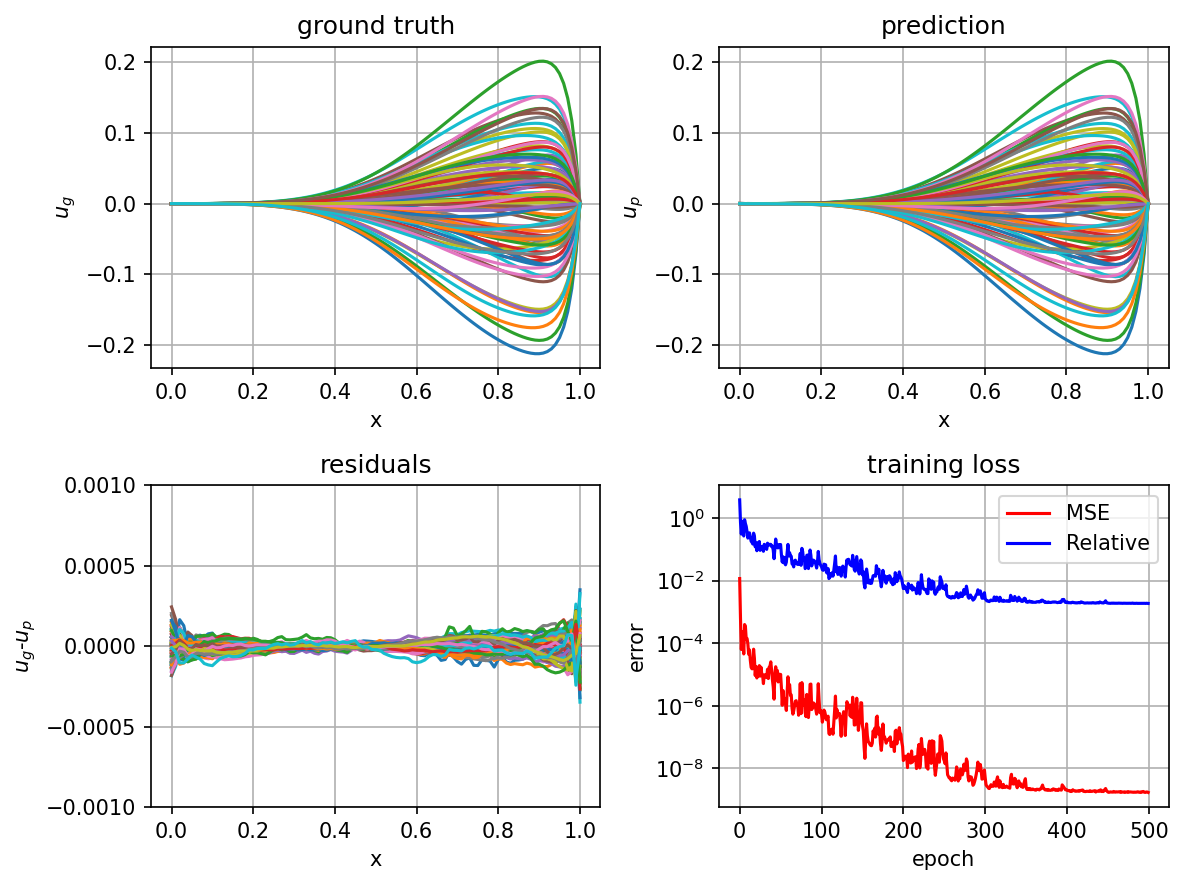

In [5]:
residual = pred-y_test
fig = plt.figure(figsize=(8,6),dpi=150)

plt.subplot(2,2,1)
plt.title("ground truth")
for i in range(ntest):
    plt.plot(x_grid,y_test[i])
plt.xlabel("x")
plt.ylabel("$u_g$")
plt.grid()

plt.subplot(2,2,2)
plt.title("prediction")
for i in range(ntest):
    plt.plot(x_grid,pred[i])
plt.xlabel("x")
plt.ylabel("$u_p$")
plt.grid()

plt.subplot(2,2,3)
plt.title("residuals")
plt.ylim([-0.001,0.001])
for i in range(ntest):
    plt.plot(x_grid,residual[i])
plt.xlabel("x")
plt.ylabel("$u_g$-$u_p$")
plt.grid()
    
plt.subplot(2,2,4)
plt.title("training loss")
plt.plot(MSE,c='r',label='MSE')
plt.plot(L2,c='b',label='Relative')
plt.legend()
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("error")
plt.grid()

plt.tight_layout()
plt.show()

In [6]:
v = torch.zeros(ntest)
m = torch.zeros(ntest)
for i in range(ntest):
    v[i] = torch.var(residual[i],unbiased=False)
    m[i] = torch.mean(residual[i])
print(torch.mean(m),torch.mean(v))

tensor(-8.8244e-07) tensor(1.0926e-09)


In [7]:
mse = MSE.numpy().reshape(1,MSE.shape[0])
l2 = L2.numpy().reshape(1,L2.shape[0])
loss = np.concatenate((mse,l2))
np.save("data/spno_loss_ib.npy",loss)
torch.save(model,"model/spno_ib")